In [403]:
import re
import os
import math
import json
import igraph

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

from time import time
from pprint import pprint
from random import sample

from itertools import groupby
from itertools import combinations

from collections import defaultdict

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.datasets.base import Bunch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering

from networkx.readwrite import json_graph

from matplotlib import pyplot as plt

%matplotlib inline

In [340]:
def abs_dist(attr='price'):
    def _inner(a, b):
        return abs(a[attr] - b[attr])
    return _inner

In [256]:
def equal_dist(attr='name'):
    def _inner(a, b):
        if a[attr] == b[attr]:
            return 0.0
        else:
            return 1.0
    return _inner

In [257]:
class Distance:
    distances = [
        abs_dist(attr='price'),
        equal_dist(attr='name'),
    ]
    def __call__(self, a, b):
        distances = []
        for distance in self.distances:
            distances.append(distance(a, b))
        return np.array(distances)

## clean up prices

In [258]:
def convert_price(price):
    price = str(price)
    if ',' in price:
        if '.' in price:
            price = price.replace('.', '')
        price = price.replace(',', '.')
        
    if ' EUR' in price:
        price = price.replace(' EUR', '')

    try:
        return float(price)
    except ValueError:
        # print('<{}>'.format(price))
        return None

## read products feed

In [259]:
products = pd.read_csv('products.csv', error_bad_lines=False, converters={'price': convert_price})
products = products.drop('Unnamed: 0', 1)
products = products[~products.price.isnull()]
list(products.columns)

//anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


['privateid',
 'name',
 'shortdescription',
 'brand',
 'ean',
 'price',
 'type',
 'shop']

In [260]:
products.shape

(384546, 8)

## group by ean and get samples with at least 5 items

In [261]:
# dunno why this is so slow
# ean_grouped = products.groupby('ean').filter(lambda x: len(x) > 5)

In [375]:
# select only eans which appear in more than 5 shops
shops_for_ean = defaultdict(set)
for ean, shop in zip(products.ean, products.shop):
    shops_for_ean[ean].add(shop)
good_eans = list({ean for ean, shops in shops_for_ean.items() if len(shops) > 5})
#sample_products = products[products.ean.isin(pd.Series(list(good_eans)).sample(n=10))]
#sample_eans = sorted(good_eans)[380:390]
sample_eans = sample(good_eans, 10)
sample_products = products[products.ean.isin(pd.Series(sample_eans))]
#sample_products = products[products.ean.isin(pd.Series(list(good_eans)))]
#print(sample_products.shape)

## create sample dataset

In [376]:
dataset = Bunch()
dataset.data = sample_products
dataset.target = sample_products.ean
dataset.true_k = np.unique(dataset.target).shape[0]

In [377]:
dataset.data[['shop', 'ean', 'name', 'brand', 'type', 'price']].sort(['ean'])

,shop,ean,name,brand,type,price
303087,3530,4024859050050,"Jüscha JÜSCHA Locher/T 5005, Maße 28,7 x 6,2 x...",Jüscha,Büro & Schreibwaren > Bürobedarf > Terminplanu...,24.93
305298,3583,4024859050050,Jüscha-Bind Bind System-Locher T-5005 für DIN ...,Jüscha-Bind,Büro & Schreibwaren > Schreibwaren > Abheften ...,15.40
236891,1686,4024859050050,bind Systemlocher für A-5 bis A-4 Formate T-5005,bind,Büro & Schreibwaren > Bürobedarf > Terminplanu...,18.90
238652,1819,4024859050050,"bind-System Locher Modell T-5005, für A5 - A4 ...",Bind,Büro & Schreibwaren > Schreibwaren > Abheften ...,16.74
239845,1828,4024859050050,"Jüscha Locher T 5005 28,7 x 6,2 x 6,7 cm schwarz",Jüscha,Büro & Schreibwaren > Bürobedarf > Terminplanu...,12.63
241721,1842,4024859050050,BIND Kalender Systemlocher für DIN A5 und A4,Bind,Büro & Schreibwaren > Bürobedarf > Terminplanu...,18.99
276608,2832,4043619181360,"Delock Einbaurahmen 3,5 zu 5,25",Delock,Hardware|Zubehör,3.30
274157,2782,4043619181360,"Festplatten-Einbaurahmen für 8,9cm/ 3.5 Gerät...",DeLock,Festplatten,1.80
234731,1567,4043619181360,"Delock Einbaurahmen Delock 5,25 für 3,5 Gerät ...",Delock,Computer & Software > PC Zubehör,7.05
276364,2784,4043619181360,"Festplatten-Einbaurahmen für 8,9cm/ 3.5 Gerät...",DeLock,Festplatten,1.80


## feature extraction

In [378]:
class EmptyFitMixin:
    def fit(self, x, y=None):
        return self

In [379]:
class ItemSelector(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def __init__(self, key):
        self.key = key

    def transform(self, df):
        values = np.array(df[self.key])
        return values.reshape(values.shape[0], 1)

In [380]:
class TextExtractor(BaseEstimator, TransformerMixin, EmptyFitMixin):
    """Extract the text from a product in a single pass.

    Takes a pandas dataframe and produces a series of texts
    from joined columns defined in `text_cols`.
    """
    def __init__(self, text_cols=['name', 'shortdescription', 'brand', 'type']):
        self.text_cols = text_cols
    
    def transform(self, data):
        def join(items):
            return ' '.join([str(item) for item in items])
        
        texts = data[self.text_cols].apply(join, axis=1)
        return texts

In [411]:
class WhitespaceRemover(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def __init__(self, regex='[^0-9a-zA-Z]+'):
        self.regex = re.compile(regex)
        
    def transform(self, data):
        return (self.regex.sub('', row) for row in data)        

In [381]:
class CosineDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        cosine_similarity = linear_kernel(X, X)
        return 1.0 - cosine_similarity

In [382]:
class NumericDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        return manhattan_distances(X)

In [383]:
class CombineDistances(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        parts_num = X.shape[1] / X.shape[0]
        parts = np.split(X, parts_num, axis=1)
        # combine with euclidean distance
        return np.sqrt(np.sum(p**2 for p in parts))

In [384]:
simple_features = FeatureUnion(
    transformer_list=[

        # Pipeline for pulling features from the text columns
        ('text_tfidf', Pipeline([
            # Extract text data from products
            ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
            ('tfidf', TfidfVectorizer()),
            ('svd', TruncatedSVD(2)),
            ('normalizer', Normalizer(copy=False)),
        ])),

        # Pipeline for price
        ('price', Pipeline([
            ('selector', ItemSelector(key='price')),
        ])),
    ],
)

In [385]:
pipeline_simple = Pipeline([
    # Use FeatureUnion to extract features from text and price
    ('features', simple_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [386]:
#pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

In [413]:
distance_features = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for pulling features from the text columns
            # and build a cosine distance matrix from it
            ('text_tfidf', Pipeline([
                ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
                ('tfidf', TfidfVectorizer()),
                ('tfidf_distance', CosineDistance()),
            ])),
                    
            # Pipeline for pulling ngram features from the name column
            ('text_tfidf', Pipeline([
                ('text', TextExtractor(text_cols=['name'])),
                ('whitespace_remove', WhitespaceRemover()),
                ('tfidf', TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5))),
                ('tfidf_distance', CosineDistance()),
            ])),

            # Pipeline for price
            ('price', Pipeline([
                ('selector', ItemSelector(key='price')),
                ('price_distance', NumericDistance()),
                ('normalizer', Normalizer(copy=False)),
            ])),
        ],
    )),
    ('combine', CombineDistances()),
])

In [419]:
pipeline_distances = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('distances', distance_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [420]:
#X = pipeline_distances.transform(dataset.data)
#pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

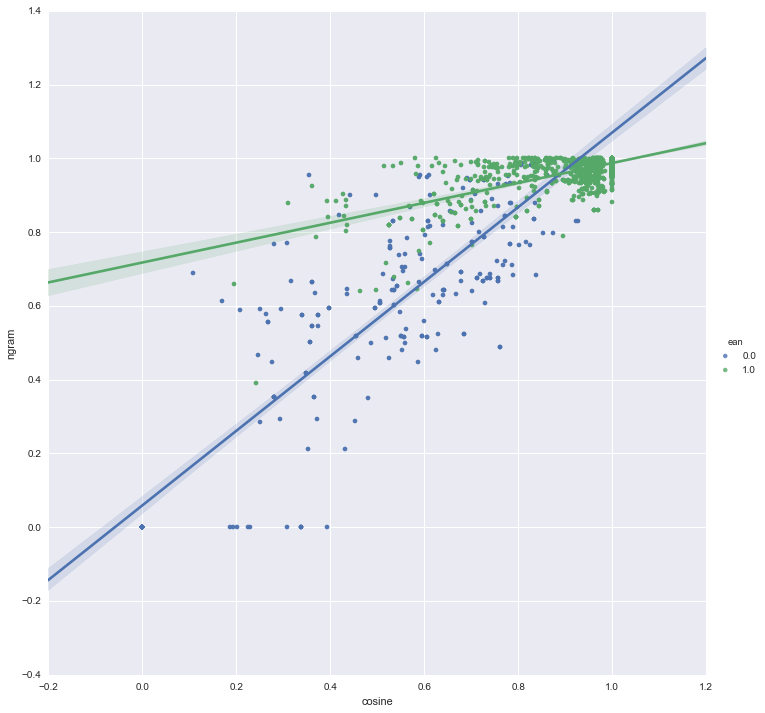

In [422]:
X_cosine_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[0][1].fit_transform(dataset.data).flatten()
X_ngram_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[1][1].fit_transform(dataset.data).flatten()
X_price_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[2][1].transform(dataset.data).flatten()
X_ean_dist = NumericDistance().transform(ItemSelector(key='ean').transform(dataset.data)).flatten()
X_ean_dist[X_ean_dist > 0] = 1
df = pd.DataFrame({'cosine': X_cosine_dist, 'price': X_price_dist, 'ngram': X_ngram_dist, 'ean': X_ean_dist})
#pp = sns.pairplot(df, hue="ean", vars=['cosine', 'price'], diag_kind="kde")
#sns.jointplot("cosine", "price", data=df, kind='scatter', size=10);
#sns.pairplot(df, x_vars=["cosine"], y_vars=["price"], hue="ean", size=10, kind="scatter")
sns.lmplot(x="cosine", y="ngram", hue="ean", data=df, size=10) # good

In [417]:
X_ngram_dist

array([ 0.        ,  0.19667651,  0.08344396, ...,  0.32079179,
        0.06299866,  0.        ])

In [391]:
help(sns.lmplot)

Help on function lmplot in module seaborn.linearmodels:

lmplot(x, y, data, hue=None, col=None, row=None, palette=None, col_wrap=None, size=5, aspect=1, markers='o', sharex=True, sharey=True, hue_order=None, col_order=None, row_order=None, legend=True, legend_out=True, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=False, x_jitter=None, y_jitter=None, scatter_kws=None, line_kws=None)
    Plot data and regression model fits across a FacetGrid.
    
    This function combines :func:`regplot` and :class:`FacetGrid`. It is
    intended as a convenient interface to fit regression models across
    conditional subsets of a dataset.
    
    When thinking about how to assign variables to different facets, a general
    rule is that it makes sense to use ``hue`` for the most important
    comparison, followed by ``col`` and ``row``. Ho

In [393]:
def match_kdeplot(df):
    sns.set(style="darkgrid")

    pos_cosine = df['cosine'][df['ean'] == 0]
    pos_price = df['price'][df['ean'] == 0]
    neg_cosine = df['cosine'][df['ean'] == 1]
    neg_cosine = neg_cosine[neg_cosine < 0.98]
    neg_price = df['price'][df['ean'] == 1]
    neg_price = neg_price[neg_price < 0.2][:neg_cosine.shape[0]]

    # Set up the figure
    f, ax = plt.subplots(figsize=(12, 10))
    #ax.set_aspect("equal")

    # Draw the two density plots
    ax = sns.kdeplot(pos_cosine, pos_price, cmap="Reds", shade=True, shade_lowest=False)
    ax = sns.kdeplot(neg_cosine, neg_price, cmap="Blues", shade=True, shade_lowest=False)

    # Add labels to the plot
    red = sns.color_palette("Reds")[-2]
    blue = sns.color_palette("Blues")[-2]
    ax.text(0.1, 0.02, "match", size=16, color=red)
    ax.text(0.6, 0.075, "non-match", size=16, color=blue)

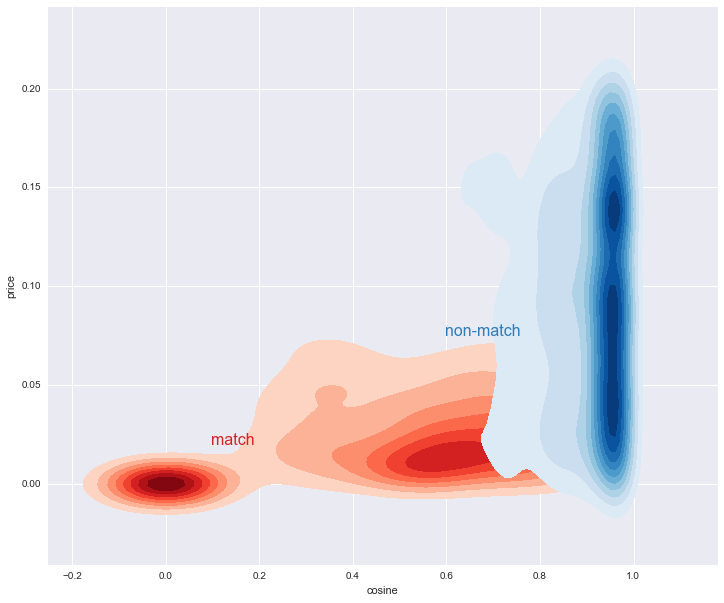

In [394]:
match_kdeplot(df)

In [395]:
pipeline_dbscan = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('distances', distance_features),
    # Use kmeans clustering on the combined features
    ('dbscan', SpectralClustering(n_clusters=dataset.true_k, eigen_solver='arpack')),
])

In [423]:
def all_combinations(ids):
    for a in ids:
        for b in ids:
            yield a, b

In [424]:
def matches_from_labels(labels):
    num = len(labels)
    pairwise = np.zeros(num ** 2).reshape(num, num)
    clusters = defaultdict(list)
    for idx, p in enumerate(labels):
        clusters[p].append(idx)
    for cluster in clusters.values():
        for i, j in all_combinations(cluster):
            pairwise[i, j] = 1
    return pairwise.flatten()

In [425]:
def pairwise_evaluation(targets, predicted):
    predicted_pairwise = matches_from_labels(predicted)
    targets_pairwise = matches_from_labels(targets)
    print(classification_report(targets_pairwise, predicted_pairwise))  

In [426]:
predicted = pipeline_distances.fit_predict(dataset.data)
#print(dataset.target)
#print(predicted)
pairwise_evaluation(dataset.target, predicted)

             precision    recall  f1-score   support

        0.0       0.98      0.97      0.97      4526
        1.0       0.74      0.84      0.79       515

avg / total       0.96      0.95      0.96      5041



In [321]:
np.arange(dataset.data.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

In [325]:
len(list(all_combinations(np.arange(10))))

100

In [427]:
def evaluate_clustering(pipeline, dataset):
    pipeline.fit(dataset.data)
    #X = pipeline.transform(dataset.data)
    predicted = pipeline.fit_predict(dataset.data, dataset.target)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset.target, predicted))
    print("Completeness: %0.3f" % metrics.completeness_score(dataset.target, predicted))
    print("V-measure: %0.3f" % metrics.v_measure_score(dataset.target, predicted))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(dataset.target, predicted))
    #print("Silhouette Coefficient: %0.3f"
    #      % metrics.silhouette_score(X, predicted, sample_size=1000))

In [428]:
def show_clusters(pipeline, dataset):
    predicted = pipeline.fit_predict(dataset.data, dataset.target)
    ean_clusters = defaultdict(list)
    predicted_clusters = defaultdict(list)
    for target, label, (_ix, row) in zip(dataset.target, predicted, dataset.data.iterrows()):
        ean_clusters[label].append(row)
        predicted_clusters[label].append(row)
    for label, cluster in predicted_clusters.items():
        pprint([r['name'] for r in cluster])
        predicted = pipeline.fit_predict(dataset.data, dataset.target)
    for label, cluster in predicted_clusters.items():
        pprint([r['name'] for r in cluster])

In [429]:
#show_clusters(pipeline_distances, dataset)

In [430]:
#%timeit pipeline_simple.fit_predict(dataset.data)

In [431]:
evaluate_clustering(pipeline_simple, dataset)

Homogeneity: 0.558
Completeness: 0.581
V-measure: 0.570
Adjusted Rand-Index: 0.270


In [432]:
evaluate_clustering(pipeline_distances, dataset)

Homogeneity: 0.951
Completeness: 0.965
V-measure: 0.958
Adjusted Rand-Index: 0.876


In [433]:
evaluate_clustering(pipeline_dbscan, dataset)

Homogeneity: 0.825
Completeness: 0.846
V-measure: 0.835
Adjusted Rand-Index: 0.628


//anaconda/lib/python3.4/site-packages/sklearn/cluster/spectral.py:425: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


## distances to graph

In [434]:
# calc distances
X = distance_features.fit_transform(dataset.data, dataset.target)

In [435]:
# convert distance matrix to graph
dt = [('distance', float)]
G = nx.from_numpy_matrix(X.view(dt))

In [436]:
# create node color lookup dict
eans = set(dataset.data.ean)
colors = [int(c.replace('#', '0x'), 16) for c in sns.color_palette("hls", len(eans)).as_hex()]
ean_colors = {e: c for e, c in zip(eans, colors)}
node_colors = dict(enumerate((ean_colors[ean] for ean in dataset.data.ean)))

## visualize distance graph with igraph and webgl

In [437]:
# create json representation of graph, reformat node format and add color to nodes
igraph_json = json_graph.node_link_data(G)
igraph_json['nodes'] = {n['id']: {'id': n['id'], 'color': node_colors[n['id']]} for n in igraph_json['nodes']}
# reduce number of edges and rename links to edges
#igraph_json['edges'] = [l for l in igraph_json['links'] if l['distance'] < 1.0 and l['distance'] > 0.1]
igraph_json['edges'] = [l for l in igraph_json['links'] if l['distance'] < 0.8 and l['distance'] > 0.0]
#igraph_json['edges'] = igraph_json['links']
len(igraph_json['edges'])

158

In [438]:
igraph.draw(igraph_json, size=(800, 600), directed=False)

## visualize distance graph with d3 and svg

In [295]:
# create json representation of graph, reformat node format and add color to nodes
d3_graph_json = json_graph.node_link_data(G)
d3_graph_json['nodes'] = [{'id': n['id'], 'color': node_colors[n['id']]} for n in d3_graph_json['nodes']]
pprint(d3_graph_json['nodes'][:2])
# filter links
d3_graph_json['links'] = [l for l in d3_graph_json['links'] if l['distance'] < 0.9 and l['distance'] > 0.0]
pprint(d3_graph_json['links'][:2])

# python json to javascript
from IPython.display import Javascript
#runs arbitrary javascript, client-side
Javascript("window.graph_json={};".format(json.dumps(d3_graph_json)))

[{'color': 6937431, 'id': 0}, {'color': 12180311, 'id': 1}]
[{'distance': 2.220446049250313e-16, 'source': 0, 'target': 0},
 {'distance': 0.8501892215265785, 'source': 0, 'target': 1}]


<IPython.core.display.Javascript object>

In [296]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [297]:
%%javascript
require(['d3'], function(d3){
  //a weird idempotency thing
  $("#chart1").remove();
  //create canvas
  var style = [
    '<style>',
    '.node {',
    '  stroke: #fff;',
    '  stroke-width: 1.5px;',
    '}',
    '.link {',
    '  stroke: #999;',
    '  stroke-opacity: .6;',
    '}',
    '</style>'
  ].join('\n');

  //element.append(style);
  element.append("<h1>distance graph</h1>")
  element.append("<div id='chart1'></div>");
        
  var width = 960,
    height = 500;

  var color = d3.scale.category20();

  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  var svg = d3.select("#chart1").append("svg")
    .attr("width", width)
    .attr("height", height);

  var graph = window.graph_json;

  force
    .nodes(graph.nodes)
    .links(graph.links)
    .start();

  var link = svg.selectAll(".link")
    .data(graph.links)
  .enter().append("line")
    .attr("class", "link")
    .style("stroke", "#999")
    .style("stroke-width", function(d) { return 1.0; });
//    .style("stroke-width", function(d) { return d.distance / 1.0; });

  var node = svg.selectAll(".node")
    .data(graph.nodes)
  .enter().append("circle")
    .attr("class", "node")
    .attr("r", 5)
    .style("fill", function(d) { return color(d.color); })
    .call(force.drag);

  node.append("title")
    .text(function(d) { return d.id; });

  force.on("tick", function() {
    link.attr("x1", function(d) { console.log('foobar: ' + d.source.x);return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  });
});

<IPython.core.display.Javascript object>

## manual distance calculations

In [485]:
distance = Distance()
distances = []
for a, b in combinations(dataset.data, 2):
    pass
    #distances.append(distance(a, b))
len(distances)

0

In [102]:
dataset.data.ean.iloc[1]

2998949374840